In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import random
import math

In [93]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, LSTM, Bidirectional, Dropout, Concatenate
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import ModelCheckpoint
import keras.backend as K

In [94]:
from numpy.lib.stride_tricks import sliding_window_view

In [95]:
import tensorflow as tf

In [96]:
from IPython.display import clear_output

## Import data and transform to dataframe

In [97]:
info = pd.DataFrame({})

# Load CSV with the metadata of each sensor file

# 'two_tubes_16cm_4cm'

for folder_distance in ['two_tubes_10cm_4cm','two_tubes_8cm_2cm','two_tubes_12cm_6cm','two_tubes_16cm_6cm','two_tubes_14cm_4cm','two_tubes_8cm_6cm','two_tubes_6cm_4cm','two_tubes_14cm_6cm','two_tubes_12cm_4cm','two_tubes_10cm_6cm']:
#for folder_distance in['two_tubes_6cm_6cm']:
#for folder_distance in['two_tubes_8cm_2cm']:

    info_aux = pd.read_csv(str(folder_distance) + '/file_data.csv')
    info = pd.concat([info, info_aux])

In [98]:
# This function is used mainly to join the original
# bitstream information to each file. It also creates 
# columns for visualization

def add_inputs_labels(df,row,i,injection_time,injection_amount,bit_duration):
    input_name = 'input_' + str(i)
    bitstream_name = 'bitstream_' + str(i)
    
    df[input_name] = 0
    df[bitstream_name] = row[bitstream_name][1:]

    time_add = 0
    for count, bit in enumerate(row[bitstream_name][1:].split()[0]):
        df.loc[(df.sim_time <= injection_time + time_add) & (df.sim_time >= time_add),input_name] = injection_amount*int(bit)
        time_add += bit_duration
    return df

In [99]:
# Load data from each sensor csv into a dataframe dictionary

data = {}

for index,row in info.sample(frac=1).reset_index(drop=True).iterrows():
    data_aux = pd.read_csv("~"+row['file_location'].replace("'",""))
    data_aux = data_aux[:] #Clip data
    data_aux = data_aux[::10].reset_index(drop=True)
    #print(data_aux.columns)
    
    for i in range(0,2):
        add_inputs_labels(data_aux,row,i,0.1,500,1)
        distance_name = 'distance_' + str(i)
        data_aux[distance_name] = row[distance_name]
    data.update({index: data_aux})


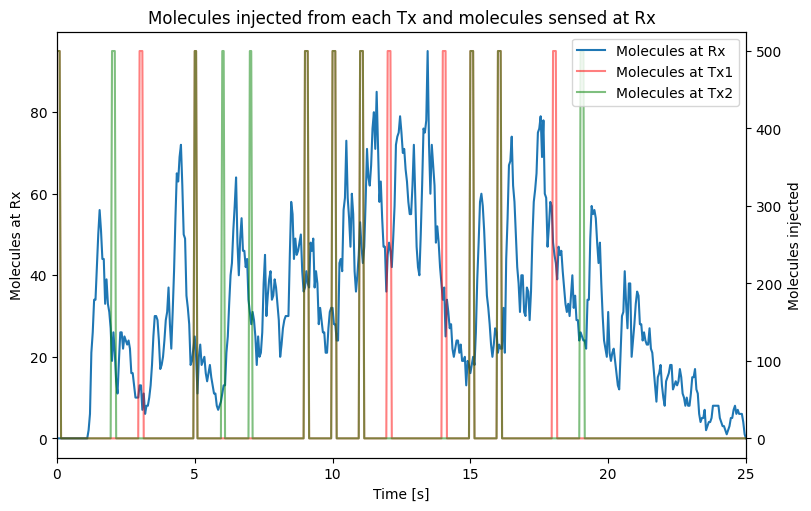

In [100]:
#Visualize each dataset
chosen_dataset = 2

sel_dataset = data[chosen_dataset]
x_axis = 'sim_time'
y_axis_1 = 'molecule_count'
y_axis_2 = 'input_0'
y_axis_3 = 'input_1'


max_x_axis = sel_dataset[x_axis].max()
max_y_axis = sel_dataset[y_axis_1].max()

fig, ax = plt.subplots(figsize=(8, 5))
ax2 = ax.twinx()
sel_dataset.plot(x=x_axis, y=y_axis_2, ax=ax2, color='red', alpha=0.5, legend=False, label = "Molecules at Tx1")
sel_dataset.plot(x=x_axis, y=y_axis_3, ax=ax2, color='green', alpha=0.5, legend=False, label = "Molecules at Tx2")
sel_dataset.plot(x=x_axis, y=y_axis_1, ax=ax, legend=False, label = "Molecules at Rx")
#ax.text(max_x_axis*0.8, max_y_axis*0.8, 'd = %f'%(data[chosen_dataset]['distance'][0]), style='italic',
#        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})


plt.title("Molecules injected from each Tx and molecules sensed at Rx")
#ax.legend(loc='upper right')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.set_xlabel("Time [s]")
ax.set_ylabel("Molecules at Rx")
ax2.set_ylabel("Molecules injected")
ax.axis(xmin=0,xmax=25)

ax2.legend(lines + lines2, labels + labels2, loc='upper right')
                
fig.tight_layout(pad=.3)
fig.savefig("two_sources_10_2_mc.png", dpi=300)

In [101]:
#Separate datasets to see performance on unseen data

data_test = dict(list(data.items())[math.floor(len(data)*0.7):len(data)-1])
data = dict(list(data.items())[:math.floor(len(data)*0.7)])

## Data Augmentation and train/test split

In [102]:
# Create the input and output matrix
    
x_all = np.zeros((len(data),data[0]['molecule_count'].size))
y_all = np.zeros((len(data),2))
y_all_bitstream = np.zeros((len(data),2,len(data[0]['bitstream_0'][0])))


for i in range(0,len(data)):
    x_all[i] = data[i]['molecule_count']
    y_all[i] = [data[i]['distance_0'][0],data[i]['distance_1'][0]]
    y_all_bitstream[i][0] = [int(i) for i in data[i]['bitstream_0'][0]]
    y_all_bitstream[i][1] = [int(i) for i in data[i]['bitstream_1'][0]]


In [364]:
data[0]

sim_time  molecule_count  input_0           bitstream_0  distance_0  \
0        0.00               0      500  11000100010110100100        0.12   
1        0.05               0      500  11000100010110100100        0.12   
2        0.10               0      500  11000100010110100100        0.12   
3        0.15               0        0  11000100010110100100        0.12   
4        0.20               0        0  11000100010110100100        0.12   
..        ...             ...      ...                   ...         ...   
496     24.80               2        0  11000100010110100100        0.12   
497     24.85               3        0  11000100010110100100        0.12   
498     24.90               3        0  11000100010110100100        0.12   
499     24.95               2        0  11000100010110100100        0.12   
500     25.00               2        0  11000100010110100100        0.12   

     input_1           bitstream_1  distance_1  
0        500  10111010001001110011        0.18  
1        500  10111010001001110011        0.18  
2        500  10111010001001110011        0.18  
3          0  10111010001001110011        0.18  
4          0  10111010001001110011        0.18  
..       ...                   ...         ...  
496        0  10111010001001110011        0.18  
497        0  10111010001001110011        0.18  
498        0  10111010001001110011        0.18  
499        0  10111010001001110011        0.18  
500        0  10111010001001110011        0.18  

[501 rows x 8 columns]

## Data training

In [384]:
from scipy.optimize import minimize

data_rate = 1
N_tx = 2500
rx_length = 0.01
tx_length = 0.01


t_i = np.arange(0,25,0.05)


def ob_prob(d,v_eff,rx_length,t):
    t_1 = (d)/(2*v_eff)
    t_2 = (d+rx_length+tx_length)/(2*v_eff)
    
    if t>=t_1 and t<=t_2:
        return 1 - (d)/(2*v_eff*t)
    if t > t_2:
        return (rx_length+tx_length)/(8*2*v_eff*t)
    else: 
        return 0


def mean_mol_number(d,sequence,v_eff,t):
    aux = 0
    
    for i in range(0,len(sequence)):
        aux = aux + sequence[i]*ob_prob(d,v_eff,rx_length,t-i*data_rate)
        
    if aux > 0:
        return N_tx*aux
    else:
        return 0.000001


def neg_log_likelihood(d_p,x,seq,v_eff):
    
    log_likelihood = 0
    
    #print("Distance between source and receiver is: " + str(d_p[0]) + " m")
    #print("Distance between source and receiver is: " + str(d_p[1]) + " m")
    
    for i in range(0,len(t_i)):
        log_likelihood = log_likelihood + x[i]*math.log(mean_mol_number(d_p[0],seq[0],v_eff[0],t_i[i]) + mean_mol_number(d_p[1],seq[1],v_eff[1],t_i[i])) - mean_mol_number(d_p[0],seq[0],v_eff[0],t_i[i]) - mean_mol_number(d_p[1],seq[0],v_eff[1],t_i[i]) 
    
    return -log_likelihood


In [328]:
y_all[9]

array([0.1 , 0.16])

In [329]:
from scipy.stats import poisson

In [331]:
data[214]

sim_time  molecule_count  input_0           bitstream_0  distance_0  \
0        0.00               0        0  01100110110111111000        0.14   
1        0.05               0        0  01100110110111111000        0.14   
2        0.10               0        0  01100110110111111000        0.14   
3        0.15               0        0  01100110110111111000        0.14   
4        0.20               0        0  01100110110111111000        0.14   
..        ...             ...      ...                   ...         ...   
496     24.80               0        0  01100110110111111000        0.14   
497     24.85               0        0  01100110110111111000        0.14   
498     24.90               0        0  01100110110111111000        0.14   
499     24.95               0        0  01100110110111111000        0.14   
500     25.00               0        0  01100110110111111000        0.14   

     input_1           bitstream_1  distance_1  
0        500  10100101010100010111        0.24  
1        500  10100101010100010111        0.24  
2        500  10100101010100010111        0.24  
3          0  10100101010100010111        0.24  
4          0  10100101010100010111        0.24  
..       ...                   ...         ...  
496        0  10100101010100010111        0.24  
497        0  10100101010100010111        0.24  
498        0  10100101010100010111        0.24  
499        0  10100101010100010111        0.24  
500        0  10100101010100010111        0.24  

[501 rows x 8 columns]

In [319]:
def v_eff_branched_mean(v_branch,v_main,d_tx_yc,d_y_rx):
    return (v_branch*d_tx_yc + v_main*d_y_rx)/(d_tx_yc+d_y_rx)

In [320]:
from scipy.stats import poisson

In [321]:
print(v_eff)

[0.06458333333333334, 0.06089285714285714]


In [355]:
model_chosen = 224
sel_dataset = data[model_chosen]

v_branch = 0.03875 # m/s
v_main_tube = 0.0775 # m/s

d_tx_1_yc = sel_dataset['distance_0'][0] - 0.08
d_tx_2_yc = sel_dataset['distance_1'][0] - 0.08
d_yc_rx = 0.08 # m

v_eff_0 = v_eff_branched_mean(v_branch,v_main_tube,d_tx_1_yc,d_yc_rx)   # m/s
v_eff_1 = v_eff_branched_mean(v_branch,v_main_tube,d_tx_2_yc,d_yc_rx) # m/s

v_eff = [v_eff_0,v_eff_1]

sequence = np.zeros([2,len(y_all_bitstream[model_chosen][0])])

sequence[0] = y_all_bitstream[model_chosen][0]
sequence[1] = y_all_bitstream[model_chosen][1]

x_first_test = x_all[model_chosen]

t_i = np.arange(0,25,0.05)

d = [sel_dataset['distance_0'][0], sel_dataset['distance_1'][0]]

n_exp_mol = [poisson.rvs(mean_mol_number(d[0],sequence[0],v_eff_0,i) + mean_mol_number(d[1],sequence[1],v_eff_1,i),1)  for i in t_i]


In [356]:
sel_dataset

sim_time  molecule_count  input_0           bitstream_0  distance_0  \
0        0.00               0      500  10100001010110011001        0.14   
1        0.05               0      500  10100001010110011001        0.14   
2        0.10               0      500  10100001010110011001        0.14   
3        0.15               0        0  10100001010110011001        0.14   
4        0.20               0        0  10100001010110011001        0.14   
..        ...             ...      ...                   ...         ...   
496     24.80               4        0  10100001010110011001        0.14   
497     24.85               7        0  10100001010110011001        0.14   
498     24.90               6        0  10100001010110011001        0.14   
499     24.95               5        0  10100001010110011001        0.14   
500     25.00               5        0  10100001010110011001        0.14   

     input_1           bitstream_1  distance_1  
0        500  11111100010010101000         0.2  
1        500  11111100010010101000         0.2  
2        500  11111100010010101000         0.2  
3          0  11111100010010101000         0.2  
4          0  11111100010010101000         0.2  
..       ...                   ...         ...  
496        0  11111100010010101000         0.2  
497        0  11111100010010101000         0.2  
498        0  11111100010010101000         0.2  
499        0  11111100010010101000         0.2  
500        0  11111100010010101000         0.2  

[501 rows x 8 columns]

In [357]:
0.775/2

0.3875

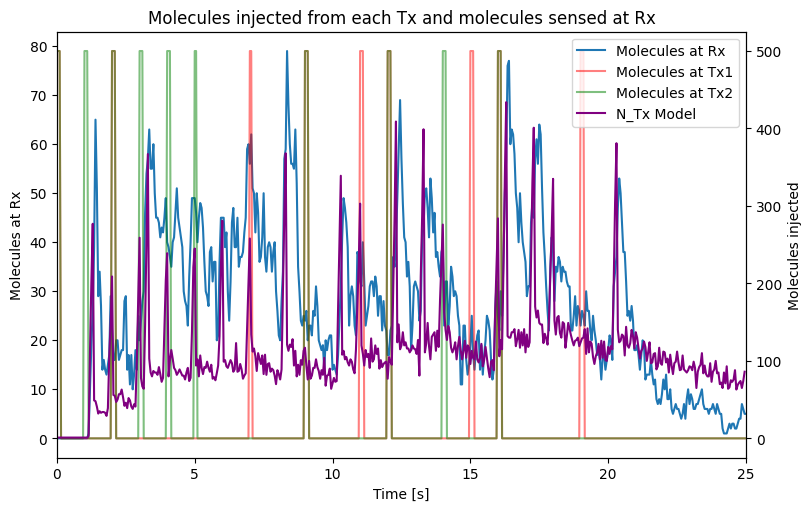

In [358]:
#Visualize each dataset

x_axis = 'sim_time'
y_axis_1 = 'molecule_count'
y_axis_2 = 'input_0'
y_axis_3 = 'input_1'


max_x_axis = sel_dataset[x_axis].max()
max_y_axis = sel_dataset[y_axis_1].max()

fig, ax = plt.subplots(figsize=(8, 5))
ax2 = ax.twinx()
sel_dataset.plot(x=x_axis, y=y_axis_2, ax=ax2, color='red', alpha=0.5, legend=False, label = "Molecules at Tx1")
sel_dataset.plot(x=x_axis, y=y_axis_3, ax=ax2, color='green', alpha=0.5, legend=False, label = "Molecules at Tx2")
sel_dataset.plot(x=x_axis, y=y_axis_1, ax=ax, legend=False, label = "Molecules at Rx")
#ax.text(max_x_axis*0.8, max_y_axis*0.8, 'd = %f'%(data[chosen_dataset]['distance'][0]), style='italic',
#        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

plt.plot(t_i,n_exp_mol,color='purple', label = "N_Tx Model")

plt.title("Molecules injected from each Tx and molecules sensed at Rx")
#ax.legend(loc='upper right')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.set_xlabel("Time [s]")
ax.set_ylabel("Molecules at Rx")
ax2.set_ylabel("Molecules injected")

ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.xlim([0,25])
                
fig.tight_layout(pad=.3)
fig.savefig("ml_two_sources_overlay_alt.png", dpi=300)

In [359]:
# Initial d_tx guess
initial_params = [0.13,0.19]

# Use the L-BFGS-B optimization method to maximize the Poisson likelihood
result = minimize(neg_log_likelihood, initial_params, args=(x_first_test,sequence,v_eff), method='Nelder-Mead')

# Extract the optimized parameter
optimized_rate = result.x

print("Optimized Distance:", optimized_rate)
print("Actual Distance:", [data[model_chosen]['distance_0'][0], data[model_chosen]['distance_1'][0]])



Distance between source and receiver is: 0.13 m
Distance between source and receiver is: 0.19 m
Distance between source and receiver is: 0.1365 m
Distance between source and receiver is: 0.19 m
Distance between source and receiver is: 0.13 m
Distance between source and receiver is: 0.1995 m
Distance between source and receiver is: 0.1365 m
Distance between source and receiver is: 0.1995 m
Distance between source and receiver is: 0.13975000000000004 m
Distance between source and receiver is: 0.20425000000000004 m
Distance between source and receiver is: 0.14300000000000002 m
Distance between source and receiver is: 0.19 m
Distance between source and receiver is: 0.14950000000000002 m
Distance between source and receiver is: 0.18525000000000003 m
Distance between source and receiver is: 0.14950000000000002 m
Distance between source and receiver is: 0.19475000000000003 m
Distance between source and receiver is: 0.15600000000000003 m
Distance between source and receiver is: 0.1971250000000

In [378]:
ml_result_table = np.zeros([y_all_test.shape[0],4])

In [379]:
ml_result_table.shape

(299, 4)

In [380]:
len(test_key_list)

299

In [372]:
# Input and output matrix for testing

test_key_list = list(data_test.keys())
first_item = test_key_list[0]

x_all_test = np.zeros((len(data_test),data_test[first_item]['molecule_count'].size))
y_all_test = np.zeros((len(data_test),2))
y_all_bitstream_test = np.zeros((len(data_test),2,len(data_test[first_item]['bitstream_0'][0])))

for i in range(first_item+1,first_item + len(data_test)):
    x_all_test[i-first_item] = data_test[i]['molecule_count']
    y_all_test[i-first_item] = [data_test[i]['distance_0'][0],data_test[i]['distance_1'][0]]
    y_all_bitstream_test[i-first_item][0] = [int(i) for i in data_test[i]['bitstream_0'][0]]
    y_all_bitstream_test[i-first_item][1] = [int(i) for i in data_test[i]['bitstream_1'][0]]

In [382]:
result.x

array([0.15658929, 0.202425  ])

In [385]:
d_yc_rx = 0.08 # m

# Initial d_tx guess
initial_params = [0.13,0.19]

for i in test_key_list:
    
    print(i)

    sequence[0] = y_all_bitstream_test[i-first_item][0]
    sequence[1] = y_all_bitstream_test[i-first_item][1]

    d_tx_1_yc = data_test[i]['distance_0'][0] - 0.08
    d_tx_2_yc = data_test[i]['distance_1'][0] - 0.08

    v_eff_0 = v_eff_branched_mean(v_branch,v_main_tube,d_tx_1_yc,d_yc_rx)   # m/s
    v_eff_1 = v_eff_branched_mean(v_branch,v_main_tube,d_tx_2_yc,d_yc_rx) # m/s

    v_eff = [v_eff_0,v_eff_1]

    result = minimize(neg_log_likelihood, initial_params, args=(x_all_test[i-first_item],sequence,v_eff), method='Nelder-Mead')

    ml_result_table[i-first_item] = [data_test[i]['distance_0'][0], data_test[i]['distance_1'][0], result.x[0], result.x[1]]
    print(ml_result_table[i-first_item])
    



700
[0.14 0.24 0.13 0.19]
701
[0.14       0.2        0.15658929 0.202425  ]
702
[0.12       0.14       0.135      0.17485714]
703
[0.1      0.16     0.126475 0.200875]
704
[0.1        0.16       0.10454351 0.2125    ]
705
[0.14       0.18       0.16267857 0.18709722]
706
[0.14       0.2        0.15658929 0.202425  ]
707
[0.14       0.16       0.16876786 0.1950625 ]
708
[0.1      0.16     0.126475 0.200875]
709
[0.14   0.2    0.1505 0.197 ]
710
[0.14       0.24       0.16267856 0.19183333]
711
[0.12      0.22      0.135     0.3234659]
712
[0.14       0.22       0.15658929 0.23892045]
713
[0.14       0.16       0.16267857 0.1834375 ]
714
[0.12       0.2        0.14787531 0.20785   ]
715
[0.12       0.22       0.12852413 0.23363636]
716
[0.1        0.16       0.10461115 0.2125    ]
717
[0.14       0.16       0.14441071 0.2066875 ]
718
[0.12       0.2        0.12854167 0.22955   ]
719
[0.14       0.18       0.16267857 0.18709722]
720
[0.12       0.18       0.135      0.20388889]
721
[0.14 

In [386]:
ml_result_table

array([[0.14      , 0.24      , 0.13      , 0.19      ],
       [0.14      , 0.2       , 0.15658929, 0.202425  ],
       [0.12      , 0.14      , 0.135     , 0.17485714],
       ...,
       [0.14      , 0.24      , 0.16430549, 0.19183333],
       [0.1       , 0.16      , 0.126475  , 0.2066875 ],
       [0.14      , 0.2       , 0.16267857, 0.191575  ]])

In [ ]:
# Model saving

#history.save('two_tubes_distance_model')

In [ ]:
info_test = pd.DataFrame({})

In [ ]:
# Testing dataset metadata

info_test = pd.DataFrame({})
for folder_distance in ['two_tubes_14cm_5cm','two_tubes_7cm_3cm']:
    info_aux = pd.read_csv(str(folder_distance) + '/file_data.csv')
    info_test = pd.concat([info_test, info_aux]) 

In [ ]:
# Testing dataset loading into dictionary

data_test = {}


for index,row in info_test.sample(frac=1).reset_index(drop=True).iterrows():
    data_aux = pd.read_csv("~"+row['file_location'].replace("'",""))
    data_aux = data_aux[:] #Clip data
    data_aux = data_aux[::].reset_index(drop=True)
    for i in range(0,2):
        add_inputs_labels(data_aux,row,i,0.1,5,1)
        distance_name = 'distance_' + str(i)
        data_aux[distance_name] = row[distance_name]
    data_test.update({index: data_aux})


In [ ]:
# Input and output matrix for testing

test_key_list = list(data_test.keys())
first_item = test_key_list[0]

x_all_test = np.zeros((len(data_test),data_test[first_item]['rel_susceptibility'].size))
y_all_test = np.zeros((len(data_test),2))

for i in range(first_item+1,first_item + len(data_test)):
    x_all_test[i-first_item] = data_test[i]['rel_susceptibility']
    y_all_test[i-first_item] = [data_test[i]['distance_0'][0],data_test[i]['distance_1'][0]]

# Dataframe for distance class performance comparison



In [387]:
unseen_data_test = pd.DataFrame(ml_result_table, columns = ['d_0','d_1','d_0_ml','d_1_ml'])

In [388]:
unseen_data_test['d_0_dif'] = unseen_data_test['d_0_ml'] - unseen_data_test['d_0']

In [389]:
unseen_data_test['d_1_dif'] = unseen_data_test['d_1_ml'] - unseen_data_test['d_1']

In [390]:
unseen_data_test['dif'] = ((unseen_data_test['d_0_ml']-unseen_data_test['d_0'])**2+(unseen_data_test['d_1_ml']-unseen_data_test['d_1'])**2)**(1/2)/(unseen_data_test['d_0']**2+unseen_data_test['d_1']**2)**(1/2)

In [391]:
unseen_data_test['class'] = unseen_data_test.apply(lambda x: str([x['d_0'],x['d_1']]),axis=1)


In [ ]:
#unseen_data_test.to_csv('unseen_data_comparison_14_5.csv')

In [ ]:
unseen_data_test['dif']

0       0.026494
1       0.054240
2       0.026896
3       0.032427
4       0.045885
          ...   
3580    0.004920
3581    0.073503
3582    0.008046
3583    0.008366
3584    0.011393
Name: dif, Length: 3585, dtype: float64

In [393]:
unseen_data_test[unseen_data_test['class']==unseen_data_test['class'].unique()[1]]

d_0  d_1    d_0_ml    d_1_ml   d_0_dif   d_1_dif       dif        class
1    0.14  0.2  0.156589  0.202425  0.016589  0.002425  0.068675  [0.14, 0.2]
6    0.14  0.2  0.156589  0.202425  0.016589  0.002425  0.068675  [0.14, 0.2]
9    0.14  0.2  0.150500  0.197000  0.010500 -0.003000  0.044731  [0.14, 0.2]
22   0.14  0.2  0.162679  0.213275  0.022679  0.013275  0.107640  [0.14, 0.2]
32   0.14  0.2  0.162679  0.191575  0.022679 -0.008425  0.099098  [0.14, 0.2]
40   0.14  0.2  0.162677  0.191575  0.022677 -0.008425  0.099092  [0.14, 0.2]
45   0.14  0.2  0.150500  0.234975  0.010500  0.034975  0.149580  [0.14, 0.2]
52   0.14  0.2  0.162679  0.191575  0.022679 -0.008425  0.099098  [0.14, 0.2]
66   0.14  0.2  0.150500  0.234975  0.010500  0.034975  0.149580  [0.14, 0.2]
80   0.14  0.2  0.162678  0.191575  0.022678 -0.008425  0.099097  [0.14, 0.2]
90   0.14  0.2  0.162679  0.191575  0.022679 -0.008425  0.099098  [0.14, 0.2]
144  0.14  0.2  0.156589  0.234975  0.016589  0.034975  0.158562  [0.14, 0.2]
153  0.14  0.2  0.162679  0.213275  0.022679  0.013275  0.107640  [0.14, 0.2]
173  0.14  0.2  0.162679  0.191575  0.022679 -0.008425  0.099098  [0.14, 0.2]
179  0.14  0.2  0.156589  0.207850  0.016589  0.007850  0.075176  [0.14, 0.2]
180  0.14  0.2  0.156589  0.202425  0.016589  0.002425  0.068675  [0.14, 0.2]
181  0.14  0.2  0.150500  0.234975  0.010500  0.034975  0.149580  [0.14, 0.2]
183  0.14  0.2  0.162679  0.191575  0.022679 -0.008425  0.099098  [0.14, 0.2]
189  0.14  0.2  0.162662  0.191574  0.022662 -0.008426  0.099036  [0.14, 0.2]
231  0.14  0.2  0.162679  0.191575  0.022679 -0.008425  0.099098  [0.14, 0.2]
284  0.14  0.2  0.162678  0.191565  0.022678 -0.008435  0.099111  [0.14, 0.2]
298  0.14  0.2  0.162679  0.191575  0.022679 -0.008425  0.099098  [0.14, 0.2]

In [394]:
classes = unseen_data_test['class'].unique()

In [395]:
classes

array(['[0.14, 0.24]', '[0.14, 0.2]', '[0.12, 0.14]', '[0.1, 0.16]',
       '[0.14, 0.18]', '[0.14, 0.16]', '[0.12, 0.22]', '[0.14, 0.22]',
       '[0.12, 0.2]', '[0.12, 0.18]'], dtype=object)

In [396]:
# Performance results

class_data = pd.DataFrame()

for i in range(0,len(classes)):
    aux = unseen_data_test[unseen_data_test['class']==unseen_data_test['class'].unique()[i]]
    aux_data = pd.DataFrame(index = [i],data = {"class": [classes[i]],"95_dif": [aux[aux['dif']<=0.05].count()[0]/aux.count()[0]*100]} )
    aux_data['90_dif'] = aux[aux['dif']<=0.1].count()[0]/aux.count()[0]*100
    aux_data['80_dif'] = aux[aux['dif']<=0.2].count()[0]/aux.count()[0]*100
    aux_data['50_dif'] = aux[aux['dif']<=0.5].count()[0]/aux.count()[0]*100
    aux_data['MAE'] = (abs(aux['d_0_ml']-aux['d_0'])+abs(aux['d_1_ml']-aux['d_1'])).mean()
    aux_data['diff'] = (aux.head(1)['d_1'] - aux.head(1)['d_0']).values[0]
    class_data = pd.concat([class_data, aux_data])

In [410]:
class_data.to_csv('ML_test_data_two_tubes.csv')

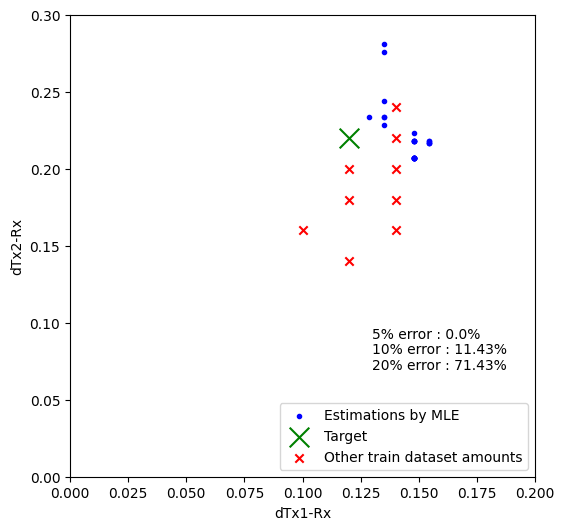

In [409]:
fig, ax = plt.subplots(figsize=(6, 6))

color_palette = "bgrcmy"

selected_class = 6

aux = unseen_data_test[unseen_data_test['class']==unseen_data_test['class'].unique()[selected_class]]

plt.scatter(aux['d_0_ml'],aux['d_1_ml'],marker='.',color='b', label='Estimations by MLE')

#plt.scatter(unseen_data_test['yp_d_0'],unseen_data_test['yp_d_1'])
for i in range(0,len(classes)):
    if i != selected_class:
        plt.scatter(eval(classes[i])[0], eval(classes[i])[1],marker='x', color='r')
    else:
        plt.scatter(eval(classes[i])[0], eval(classes[i])[1],marker='x', s=200, color='g', label='Target')
    
plt.scatter(-1, -1,marker='x', color='r', label='Other train dataset amounts')

#plt.text(0.13,0.1,'Amounts tested : '+str(class_data['class'][selected_class]))
plt.text(0.13,0.09,'5% error : '+str(round(class_data['95_dif'][selected_class],2))+str('%'))
plt.text(0.13,0.08,'10% error : '+str(round(class_data['90_dif'][selected_class],2))+str('%'))
plt.text(0.13,0.07,'20% error : '+str(round(class_data['80_dif'][selected_class],2))+str('%'))


plt.xlabel("dTx1-Rx")
plt.ylabel("dTx2-Rx")

#plt.title("Distance estimation")
plt.legend(loc='lower right')

plt.xlim(0, 0.2)
plt.ylim(0, 0.3)

fig.savefig("two_sources_distance_estimation_seen_class_" + str(selected_class) + ".png", dpi=300)
#plt.scatter(0.05,0.14,color='green',marker='x')

